In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility
import pickle
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV

pd.options.mode.chained_assignment = None  #hide any pandas warnings

c:\Users\ASUS\anaconda3\envs\python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read data

In [2]:
dt = pd.read_csv("raw-heart-data.csv")


### Watch 10 first observations

In [3]:
dt.head(10)

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No
5,6,56,1,nontypical,120,236,0,0,178,0,0.8,1,0.0,normal,No
6,7,62,0,asymptomatic,140,268,0,2,160,0,3.6,3,2.0,normal,Yes
7,8,57,0,asymptomatic,120,354,0,0,163,1,0.6,1,0.0,normal,No
8,9,63,1,asymptomatic,130,254,0,2,147,0,1.4,2,1.0,reversable,Yes
9,10,53,1,asymptomatic,140,203,1,2,155,1,3.1,3,0.0,reversable,Yes


### Drop a column

In [4]:
dt.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
dt

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,typical,110,264,0,0,132,0,1.2,2,0.0,reversable,Yes
299,68,1,asymptomatic,144,193,1,0,141,0,3.4,2,2.0,reversable,Yes
300,57,1,asymptomatic,130,131,0,0,115,1,1.2,2,1.0,reversable,Yes
301,57,0,nontypical,130,236,0,2,174,0,0.0,2,1.0,normal,Yes


### Rename the column

In [6]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']
dt

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,typical,110,264,0,0,132,0,1.2,2,0.0,reversable,Yes
299,68,1,asymptomatic,144,193,1,0,141,0,3.4,2,2.0,reversable,Yes
300,57,1,asymptomatic,130,131,0,0,115,1,1.2,2,1.0,reversable,Yes
301,57,0,nontypical,130,236,0,2,174,0,0.0,2,1.0,normal,Yes


### About the data
#### It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,

- age: The person's age in years
- sex: The person's sex (1 = male, 0 = female)
- cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
- chol: The person's cholesterol measurement in mg/dl
- fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- thalach: The person's maximum heart rate achieved
- exang: Exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
- slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- ca: The number of major vessels (0-3)
- thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- target: Heart disease (0 = no, 1 = yes)


### Change the values of the categorical variables, to improve the interpretation later on

In [7]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 'fixed'] = 'fixed defect' 
dt['thalassemia'][dt['thalassemia'] == 'reversable'] = 'reversable defect'

dt['target'][dt['target'] == 'Yes'] = 1
dt['target'][dt['target'] == 'No'] = 0


In [8]:
dt

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,typical,145,233,greater than 120mg/ml,left ventricular hypertrophy,150,no,2.3,downsloping,0.0,fixed defect,0
1,67,male,asymptomatic,160,286,lower than 120mg/ml,left ventricular hypertrophy,108,yes,1.5,flat,3.0,normal,1
2,67,male,asymptomatic,120,229,lower than 120mg/ml,left ventricular hypertrophy,129,yes,2.6,flat,2.0,reversable defect,1
3,37,male,nonanginal,130,250,lower than 120mg/ml,normal,187,no,3.5,downsloping,0.0,normal,0
4,41,female,nontypical,130,204,lower than 120mg/ml,left ventricular hypertrophy,172,no,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,male,typical,110,264,lower than 120mg/ml,normal,132,no,1.2,flat,0.0,reversable defect,1
299,68,male,asymptomatic,144,193,greater than 120mg/ml,normal,141,no,3.4,flat,2.0,reversable defect,1
300,57,male,asymptomatic,130,131,lower than 120mg/ml,normal,115,yes,1.2,flat,1.0,reversable defect,1
301,57,female,nontypical,130,236,lower than 120mg/ml,left ventricular hypertrophy,174,no,0.0,flat,1.0,normal,1


### Eliminate NA values

In [9]:
dt = dt.dropna()

In [10]:
dt

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,typical,145,233,greater than 120mg/ml,left ventricular hypertrophy,150,no,2.3,downsloping,0.0,fixed defect,0
1,67,male,asymptomatic,160,286,lower than 120mg/ml,left ventricular hypertrophy,108,yes,1.5,flat,3.0,normal,1
2,67,male,asymptomatic,120,229,lower than 120mg/ml,left ventricular hypertrophy,129,yes,2.6,flat,2.0,reversable defect,1
3,37,male,nonanginal,130,250,lower than 120mg/ml,normal,187,no,3.5,downsloping,0.0,normal,0
4,41,female,nontypical,130,204,lower than 120mg/ml,left ventricular hypertrophy,172,no,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,female,asymptomatic,140,241,lower than 120mg/ml,normal,123,yes,0.2,flat,0.0,reversable defect,1
298,45,male,typical,110,264,lower than 120mg/ml,normal,132,no,1.2,flat,0.0,reversable defect,1
299,68,male,asymptomatic,144,193,greater than 120mg/ml,normal,141,no,3.4,flat,2.0,reversable defect,1
300,57,male,asymptomatic,130,131,lower than 120mg/ml,normal,115,yes,1.2,flat,1.0,reversable defect,1


### Check data types

In [11]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels          float64
thalassemia                 object
target                      object
dtype: object

### Change Data type of 2 columns: num_major_vessels & target

In [12]:
dt['num_major_vessels'] = dt['num_major_vessels'].astype('int64')
dt['target'] = dt['target'].astype('int64')

In [13]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [14]:
dt['chest_pain_type'].unique()

array(['typical', 'asymptomatic', 'nonanginal', 'nontypical'],
      dtype=object)

### For the categorical varibles, we need to create dummy variables. I'm also going to drop the first category of each. For example, rather than having 'male' and 'female', we'll have 'male' with values of 0 or 1 (1 being male, and 0 therefore being female).

In [15]:
dt = pd.get_dummies(dt, drop_first=True)

In [16]:
dt

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_nonanginal,chest_pain_type_nontypical,chest_pain_type_typical,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,0,1,0,0,1,0,1,0,0,0,0,0,0
1,67,160,286,108,1.5,3,1,1,0,0,0,1,1,0,1,1,0,1,0
2,67,120,229,129,2.6,2,1,1,0,0,0,1,1,0,1,1,0,0,1
3,37,130,250,187,3.5,0,0,1,1,0,0,1,0,1,0,0,0,1,0
4,41,130,204,172,1.4,0,0,0,0,1,0,1,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,140,241,123,0.2,0,1,0,0,0,0,1,0,1,1,1,0,0,1
298,45,110,264,132,1.2,0,1,1,0,0,1,1,0,1,0,1,0,0,1
299,68,144,193,141,3.4,2,1,1,0,0,0,0,0,1,0,1,0,0,1
300,57,130,131,115,1.2,1,1,1,0,0,0,1,0,1,1,1,0,0,1


### Rename columns name: Chest pain type

In [17]:
dt.rename(columns = {'chest_pain_type_typical':'chest_pain_type_typical angina', 'chest_pain_type_nontypical':'chest_pain_type_atypical angina', 
                              'chest_pain_type_nonanginal':'chest_pain_type_non-anginal pain'}, inplace = True)

In [18]:
dt.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_non-anginal pain,chest_pain_type_atypical angina,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,0,1,0,0,1,0,1,0,0,0,0,0,0
1,67,160,286,108,1.5,3,1,1,0,0,0,1,1,0,1,1,0,1,0
2,67,120,229,129,2.6,2,1,1,0,0,0,1,1,0,1,1,0,0,1
3,37,130,250,187,3.5,0,0,1,1,0,0,1,0,1,0,0,0,1,0
4,41,130,204,172,1.4,0,0,0,0,1,0,1,1,0,0,0,1,1,0


In [19]:
dt

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_non-anginal pain,chest_pain_type_atypical angina,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,0,1,0,0,1,0,1,0,0,0,0,0,0
1,67,160,286,108,1.5,3,1,1,0,0,0,1,1,0,1,1,0,1,0
2,67,120,229,129,2.6,2,1,1,0,0,0,1,1,0,1,1,0,0,1
3,37,130,250,187,3.5,0,0,1,1,0,0,1,0,1,0,0,0,1,0
4,41,130,204,172,1.4,0,0,0,0,1,0,1,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,140,241,123,0.2,0,1,0,0,0,0,1,0,1,1,1,0,0,1
298,45,110,264,132,1.2,0,1,1,0,0,1,1,0,1,0,1,0,0,1
299,68,144,193,141,3.4,2,1,1,0,0,0,0,0,1,0,1,0,0,1
300,57,130,131,115,1.2,1,1,1,0,0,0,1,0,1,1,1,0,0,1


### Save processed data

In [20]:
dt.to_csv('processed-heart-data.csv', sep=',', index=False, encoding='utf-8')

### The Model


#### The next part fits a random forest model to the data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #split the data
splits = [X_train, X_test, y_train, y_test]


In [22]:
print("Training data size:", len(X_train))
print("Test data size:", len(X_test))

Training data size: 237
Test data size: 60


In [30]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [31]:
rf_tuning = RandomForestClassifier()

param_dist = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [130, 180, 230]
}

random_search_rf = RandomizedSearchCV(estimator=rf_tuning,
                                   param_distributions=param_dist,
                                   cv=5,
                                   n_iter=100,
                                   verbose=2,
                                   n_jobs=-1)

random_search_rf.fit(X_train, y_train)
random_search_rf.best_params_

In [32]:
save_model_path = 'D:\Data\Life Sciences\model'

In [33]:
def save_models(models_dict, save_folder_path, running_count):
  for model in models_dict:
    filename = model['label'] + '_{}.pkl'.format(str(running_count))
    with open(save_model_path + '/' + filename, 'wb') as f:
      pickle.dump(model, f)

In [34]:
model = RandomForestClassifier(**random_search_rf.best_params_)

In [35]:
save_models(models_dict=[{"label": "RF", "model": model}], save_folder_path=save_model_path, running_count='optimal')

#### Plot the consequent decision tree, to see what it's doing

In [36]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

#### Add Graphwiz to PATH for current user

In [37]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [38]:
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

#### Evaluate the model

In [39]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

#### Assess the fit with a confusion matrix

In [40]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[30,  5],
       [ 3, 22]], dtype=int64)

#### Diagnostic tests are often sold, marketed, cited and used with **sensitivity** and **specificity** as the headline metrics. Sensitivity and specificity are defined as,

$$
Sensitivity = \frac{True Positives}{TruePositives+FalseNegatives}
$$

$$
Specificity = \frac{True Negatives}{True Negatives + FalsePositives}
$$

#### Calculate the result

In [41]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', round(sensitivity,2 ) )
specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', round(specificity,2) )

Sensitivity :  0.91
Specificity :  0.81


#### Check with a Receiver Operator Curve (ROC),

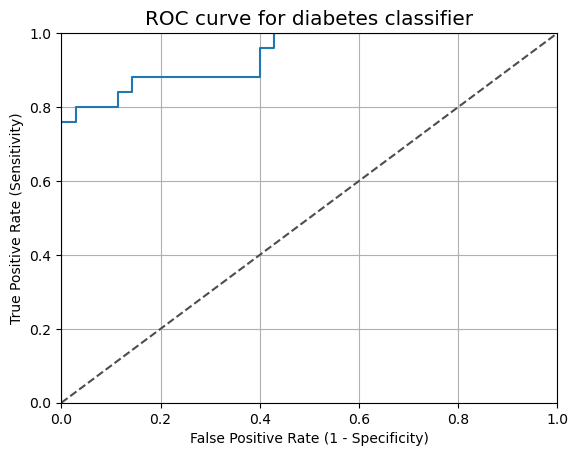

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Another common metric is the Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail


Let's see what the above ROC gives us,

In [43]:
auc = auc(fpr, tpr)
print( round(auc,2))

0.94


#### Conclusion: It's working well !!!

In [45]:
importance = pd.DataFrame({'feature':X_train.columns, 'importance': model.feature_importances_})
print(importance.sort_values('importance', ascending=False))

                                    feature  importance
3                   max_heart_rate_achieved    0.141477
4                             st_depression    0.118136
5                         num_major_vessels    0.115227
16                       thalassemia_normal    0.106273
17            thalassemia_reversable defect    0.080547
0                                       age    0.071318
13              exercise_induced_angina_yes    0.064825
1                    resting_blood_pressure    0.060224
2                               cholesterol    0.057746
15                       st_slope_upsloping    0.035895
7          chest_pain_type_non-anginal pain    0.030016
6                                  sex_male    0.028899
14                            st_slope_flat    0.028560
9            chest_pain_type_typical angina    0.020821
12                          rest_ecg_normal    0.013046
8           chest_pain_type_atypical angina    0.010512
11    rest_ecg_left ventricular hypertrophy    0

#### SHAP values

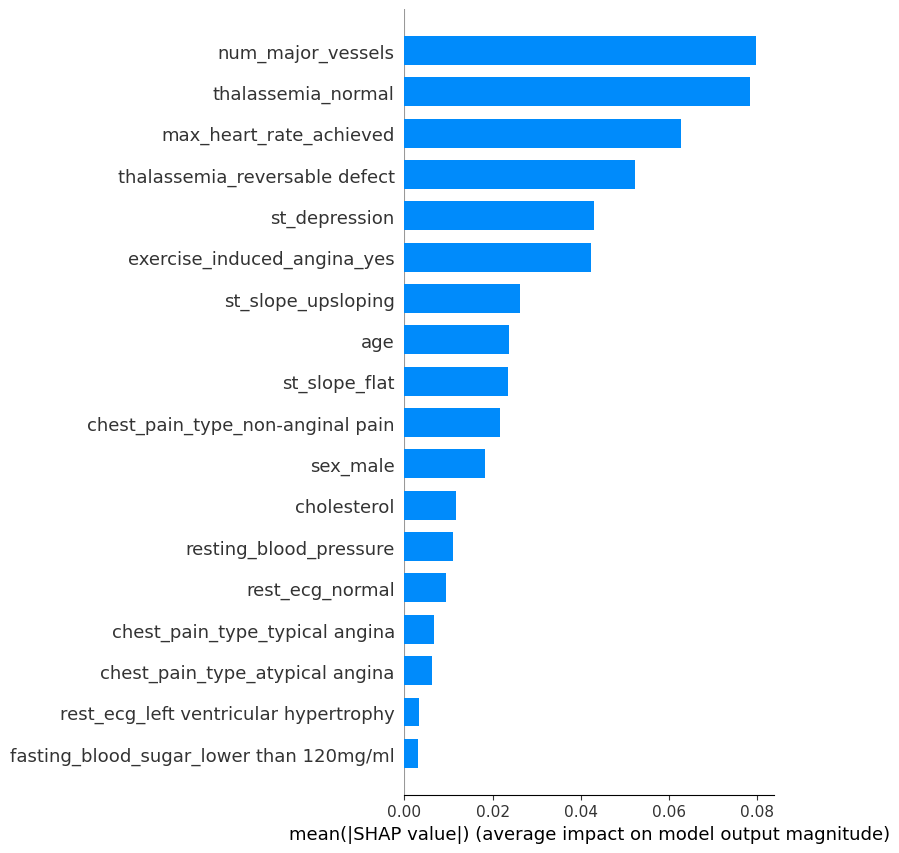

In [46]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

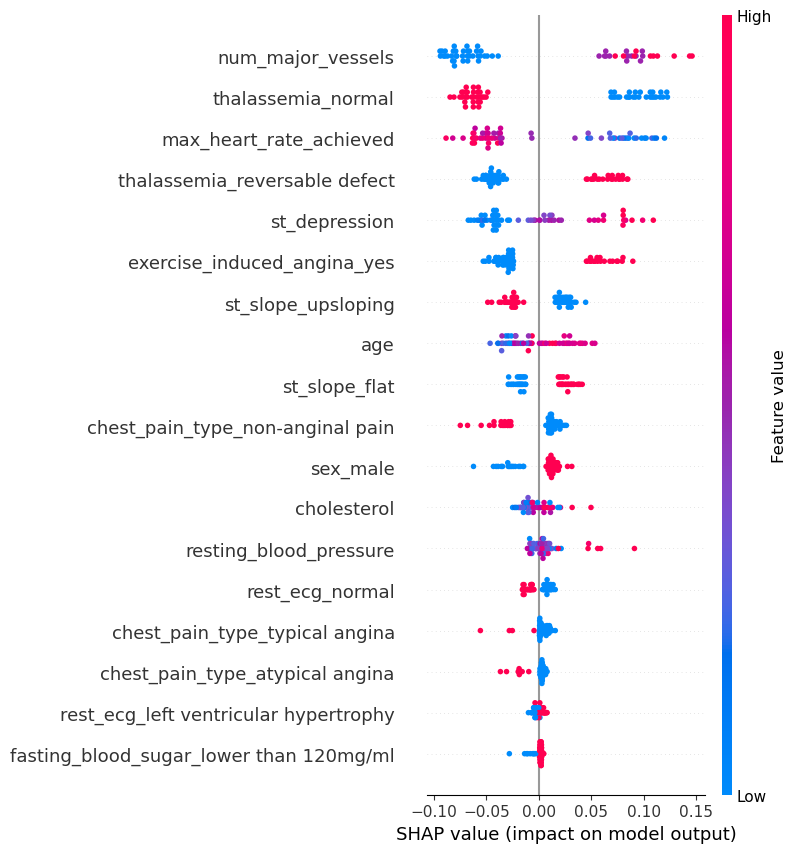

In [47]:
shap.summary_plot(shap_values[1], X_test)